In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
import os
import datetime
from sklearn.linear_model import LinearRegression  
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy import stats
from scipy.stats import pearsonr
import joblib
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')


In [2]:
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab20", 16)
sns.set(font="Calibri")
sns.set_context('talk')

In [3]:
df = pd.read_csv('train_set.csv', parse_dates= ['created_at'])
df

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,1199,4374,21,14,6834,130,95.0
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,21,14,6834,130,139.0
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,21,14,6834,130,46.0
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,21,14,6834,130,33.0
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,21,14,6834,130,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,2020-01-22 04:00:00+03:00,USEmbassy,128.917907,134.155814,124.504884,138.842326,0.670000,20.091667,0.299255,32.592686,1199,4374,21,14,6834,130,116.0
10928,2020-01-30 20:00:00+03:00,USEmbassy,29.963721,33.015814,28.620698,33.943256,0.834167,22.450000,0.299255,32.592686,1199,4374,21,14,6834,130,38.0
10929,2020-12-17 13:00:00+03:00,Makerere,51.620000,63.634444,49.422222,61.824444,0.629333,25.108333,0.333501,32.568561,1233,6340,21,28,8518,475,38.3
10930,2020-02-05 21:00:00+03:00,USEmbassy,54.548864,65.714318,51.484773,65.361818,0.888333,20.733333,0.299255,32.592686,1199,4374,21,14,6834,130,67.0


In [4]:
df.shape

(10932, 17)

In [5]:
def get_date_features(df_tmp):
    D_COL = 'created_at'
    for attr in ['hour', 'day', 'dayofweek', 'month','week', 'year']:
        df_tmp[f'{D_COL}_{attr}'] = getattr(df_tmp[D_COL].dt, attr)
    return df_tmp

In [6]:
data = get_date_features(df)

In [7]:
data

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,...,14,6834,130,95.0,8,2,0,12,49,2019
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,...,14,6834,130,139.0,2,17,1,3,12,2020
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,...,14,6834,130,46.0,5,13,6,10,41,2019
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,...,14,6834,130,33.0,11,4,5,4,14,2020
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,...,14,6834,130,60.0,20,22,6,3,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,2020-01-22 04:00:00+03:00,USEmbassy,128.917907,134.155814,124.504884,138.842326,0.670000,20.091667,0.299255,32.592686,...,14,6834,130,116.0,4,22,2,1,4,2020
10928,2020-01-30 20:00:00+03:00,USEmbassy,29.963721,33.015814,28.620698,33.943256,0.834167,22.450000,0.299255,32.592686,...,14,6834,130,38.0,20,30,3,1,5,2020
10929,2020-12-17 13:00:00+03:00,Makerere,51.620000,63.634444,49.422222,61.824444,0.629333,25.108333,0.333501,32.568561,...,28,8518,475,38.3,13,17,3,12,51,2020
10930,2020-02-05 21:00:00+03:00,USEmbassy,54.548864,65.714318,51.484773,65.361818,0.888333,20.733333,0.299255,32.592686,...,14,6834,130,67.0,21,5,2,2,6,2020


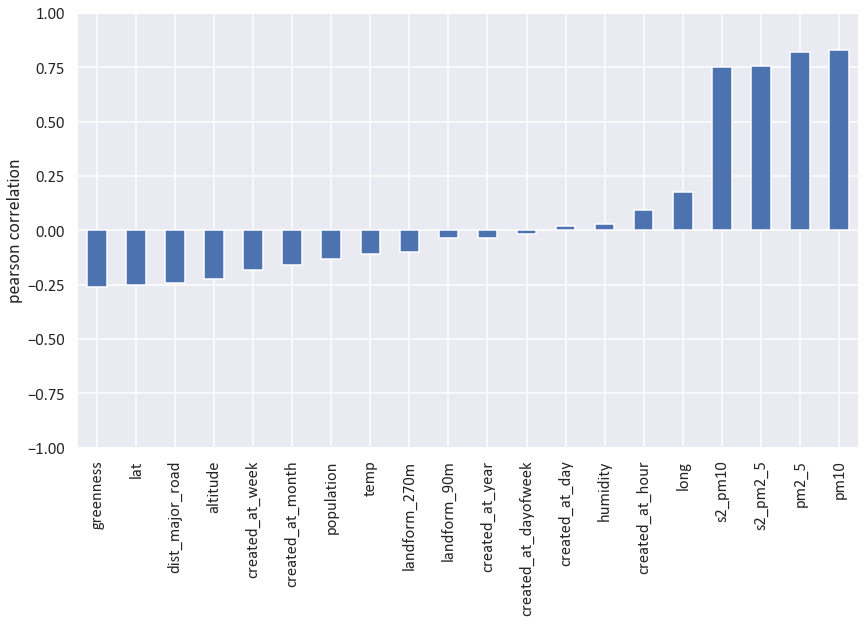

greenness              -0.260556
lat                    -0.250891
dist_major_road        -0.243103
altitude               -0.222725
created_at_week        -0.181289
created_at_month       -0.158169
population             -0.132610
temp                   -0.109582
landform_270m          -0.098641
landform_90m           -0.035147
created_at_year        -0.034572
created_at_dayofweek   -0.016898
created_at_day          0.018598
humidity                0.030603
created_at_hour         0.092069
long                    0.176348
s2_pm10                 0.752732
s2_pm2_5                0.755162
pm2_5                   0.821103
pm10                    0.829827
dtype: float64

In [8]:
y = (data['ref_pm2_5'])
#fields = list(data.columns[:-1])  # everything except "color"
fields = ['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
        'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year']
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)


plt.figure(figsize=(14,8))
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')
plt.show()

correlations

In [9]:
data.columns

Index(['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
       'ref_pm2_5', 'created_at_hour', 'created_at_day',
       'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year'],
      dtype='object')

In [10]:
def visualise_prediction_vs_actual(df_, method):
    fig = plt.figure(figsize=(14,6))
    plt.rcParams.update({'font.size':14, 'font.weight':'bold'})
    plt.plot(df_.index, 
             df_['Actual'], linestyle='solid', label='Actual')  
    plt.plot(df_.index, 
             df_['Predicted'], linestyle='solid', label='Predicted')

    chart_title =  'Actual Vs Predicted using '+ method
    plt.title(chart_title,fontsize=20)
    plt.ylabel('PM2.5', fontsize=20)
    plt.xlabel('index', fontsize=20)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    fig.savefig(chart_title+'.png')
    
    
def get_model_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mse =  metrics.mean_squared_error(y_test, y_pred)
    actual = pd.Series(y_test)
    predicted = pd.Series(y_pred)
    correlation = actual.corr(predicted)
    r_squared = round((correlation*correlation),4)
    print('Mean Absolute Error: ',mae)     
    print('Root Mean Squared Error: ', rmse)
    print('Mean Squared Error: ',mse) 
    print('Correlation: ', correlation)
    print('R-Squared Value: ', r_squared)
    return mae, rmse, mse, correlation, r_squared


def preprocessing_own(df):
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
    df['hour_of_day'] = [datetime.fromisoformat(n).hour for n in df['created_at']]
    df['s2_pm2_5'] = train_set['s2_pm2_5'].mask(df['s2_pm2_5']==0).fillna(df['pm2_5'])
    df['s2_pm10'] = train_set['s2_pm10'].mask(df['s2_pm10']==0).fillna(df['pm10'])
    df.drop(columns=['site', 'created_at'], axis=1, inplace=True)
    return df

### MULTILINEAR REGRESSION

### SVM

### RANDOM FOREST

### GRADIENT BOOSTING TREE

### NEURAL  NETWORKS

# Evaluation on Held out test set

In [11]:
df_test = pd.read_csv('test_set.csv', parse_dates= ['created_at'])
data_test = get_date_features(df_test)
df_test_solution = pd.read_csv('test_solution.csv')

In [12]:
df_test

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2020-03-20 12:00:00+03:00,USEmbassy,9.903636,10.259545,8.852727,10.097727,0.748000,26.491667,0.299255,32.592686,...,21,14,6834,130,12,20,4,3,12,2020
1,2019-10-12 06:00:00+03:00,USEmbassy,38.428333,45.940714,40.087143,48.159762,0.995000,18.225000,0.299255,32.592686,...,21,14,6834,130,6,12,5,10,41,2019
2,2019-12-13 17:00:00+03:00,USEmbassy,13.278000,14.967333,0.000000,0.000000,0.687500,24.891667,0.299255,32.592686,...,21,14,6834,130,17,13,4,12,50,2019
3,2019-11-13 09:00:00+03:00,USEmbassy,36.304000,40.366750,89.182500,93.572500,0.868417,22.616667,0.299255,32.592686,...,21,14,6834,130,9,13,2,11,46,2019
4,2019-08-07 19:00:00+03:00,USEmbassy,56.686410,67.412308,55.048974,66.089487,0.782083,23.350000,0.299255,32.592686,...,21,14,6834,130,19,7,2,8,32,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2020-01-19 00:00:00+03:00,USEmbassy,75.804091,79.502045,72.147273,80.552273,0.730833,22.300000,0.299255,32.592686,...,21,14,6834,130,0,19,6,1,3,2020
2729,2020-10-25 11:00:00+03:00,Nakawa,20.805238,22.663810,22.465238,24.824048,0.640500,26.825000,0.331740,32.609510,...,31,-11,4780,500,11,25,6,10,43,2020
2730,2021-01-13 06:00:00+03:00,Makerere,76.253333,82.311667,72.468333,81.742500,0.987333,19.291667,0.333501,32.568561,...,21,28,8518,475,6,13,2,1,2,2021
2731,2019-08-13 13:00:00+03:00,USEmbassy,37.669767,44.455581,37.168837,43.949767,0.660667,25.550000,0.299255,32.592686,...,21,14,6834,130,13,13,1,8,33,2019


In [13]:
df_test_solution

,ref_pm2_5
0,30.0
1,44.0
2,27.0
3,48.0
4,57.0
...,...
2728,75.0
2729,24.2
2730,54.0
2731,42.0


In [14]:
X_data_test = data_test['pm2_5'].values
X_data_test = X_data_test.reshape((-1, 1))
y_data_test = df_test_solution['ref_pm2_5'].values

# MULTIPLE FEATURES 

### Feature Engineering

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
pm2_5,10932.0,51.543471,34.588032,0.567273,29.370546,43.659269,63.956750,335.433023
pm10,10932.0,59.794230,38.214016,0.595909,33.740357,54.310698,74.936473,407.713953
s2_pm2_5,10932.0,48.183486,34.259708,0.000000,26.605675,42.184865,60.999375,330.275152
s2_pm10,10932.0,56.765928,38.876526,0.000000,30.255752,52.554515,73.278125,384.627045
humidity,10926.0,0.824849,0.135233,0.307167,0.735000,0.857208,0.933729,1.000000
temp,10915.0,21.962882,2.803965,16.175000,19.775000,21.350000,24.025000,30.781818
lat,10932.0,0.314090,0.016704,0.299255,0.299255,0.299255,0.333501,0.333501
long,10932.0,32.588472,0.013861,32.568561,32.568561,32.592686,32.592686,32.609510
altitude,10932.0,1207.406696,16.369252,1191.000000,1199.000000,1199.000000,1233.000000,1233.000000
greenness,10932.0,5166.938986,904.989287,4374.000000,4374.000000,4374.000000,6340.000000,6340.000000


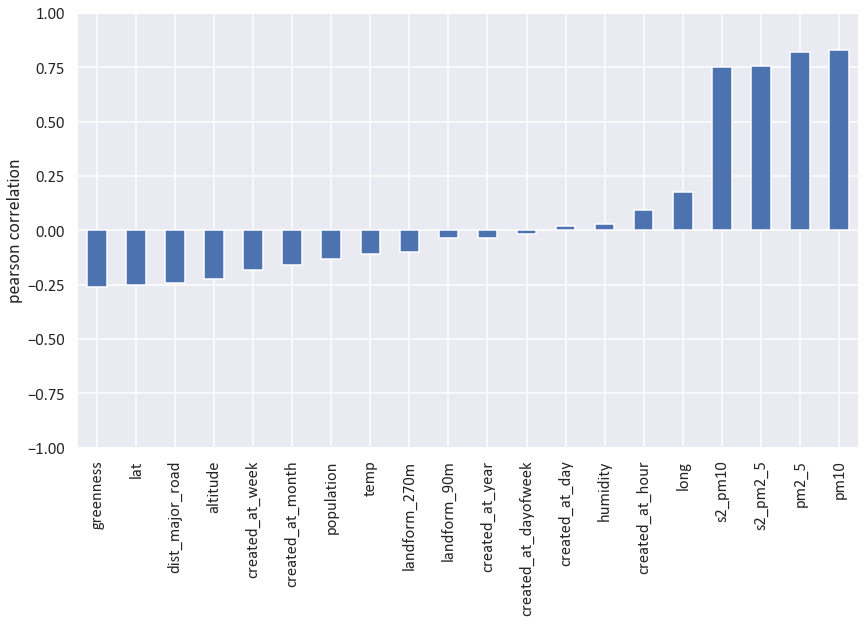

greenness              -0.260556
lat                    -0.250891
dist_major_road        -0.243103
altitude               -0.222725
created_at_week        -0.181289
created_at_month       -0.158169
population             -0.132610
temp                   -0.109582
landform_270m          -0.098641
landform_90m           -0.035147
created_at_year        -0.034572
created_at_dayofweek   -0.016898
created_at_day          0.018598
humidity                0.030603
created_at_hour         0.092069
long                    0.176348
s2_pm10                 0.752732
s2_pm2_5                0.755162
pm2_5                   0.821103
pm10                    0.829827
dtype: float64

In [16]:
y = (data['ref_pm2_5'])
#fields = list(data.columns[:-1])  # everything except "color"
fields = ['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
        'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year']
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)


plt.figure(figsize=(14,8))
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')
plt.show()

correlations

In [17]:
data.head().T

,0,1,2,3,4
created_at,2019-12-02 08:00:00+03:00,2020-03-17 02:00:00+03:00,2019-10-13 05:00:00+03:00,2020-04-04 11:00:00+03:00,2020-03-22 20:00:00+03:00
site,USEmbassy,USEmbassy,USEmbassy,USEmbassy,USEmbassy
pm2_5,74.0887,88.3502,47.5405,24.5676,46.6449
pm10,83.7671,96.003,58.6723,27.1514,57.5551
s2_pm2_5,0,86.9933,48.6841,23.4067,46.1951
s2_pm10,0,107.93,60.5051,27.3164,60.0757
humidity,0.962917,0.967667,0.99925,0.7835,0.721833
temp,21.475,19.2333,18.9167,25.475,22.9167
lat,0.299255,0.299255,0.299255,0.299255,0.299255
long,32.5927,32.5927,32.5927,32.5927,32.5927


In [18]:
## deal with null values
## replace values for s2 with s1
## one hot encode
## transformation on lat & long

In [19]:
data[data.isna().any(axis=1)]

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
861,2019-12-11 01:00:00+03:00,USEmbassy,31.267045,36.877500,0.000000,0.000000,0.982500,NaN,0.299255,32.592686,...,14,6834,130,36.0,1,11,2,12,50,2019
1190,2019-12-11 03:00:00+03:00,USEmbassy,35.550000,43.474634,0.000000,0.000000,0.995833,NaN,0.299255,32.592686,...,14,6834,130,46.0,3,11,2,12,50,2019
1391,2019-12-11 06:00:00+03:00,USEmbassy,19.427273,22.002045,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,14,6834,130,30.0,6,11,2,12,50,2019
1529,2019-12-11 11:00:00+03:00,USEmbassy,29.901111,34.643556,0.000000,0.000000,0.780000,NaN,0.299255,32.592686,...,14,6834,130,41.0,11,11,2,12,50,2019
2274,2021-01-29 16:00:00+03:00,USEmbassy,28.912727,42.107727,32.221818,38.336818,NaN,23.008333,0.299255,32.592686,...,14,6834,130,40.0,16,29,4,1,4,2021
3277,2020-11-10 16:00:00+03:00,Nakawa,26.381190,30.775952,26.815238,32.159524,NaN,22.566667,0.331740,32.609510,...,-11,4780,500,0.8,16,10,1,11,46,2020
3335,2019-12-11 07:00:00+03:00,USEmbassy,32.801136,39.884091,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,14,6834,130,46.0,7,11,2,12,50,2019
4273,2019-12-11 00:00:00+03:00,USEmbassy,43.462955,55.111818,0.000000,0.000000,0.969167,NaN,0.299255,32.592686,...,14,6834,130,49.0,0,11,2,12,50,2019
4361,2020-02-25 14:00:00+03:00,USEmbassy,44.975946,52.540541,43.596486,53.765946,NaN,21.566667,0.299255,32.592686,...,14,6834,130,50.0,14,25,1,2,9,2020
5315,2019-12-20 13:00:00+03:00,USEmbassy,22.913462,23.791923,21.974231,24.215769,NaN,NaN,0.299255,32.592686,...,14,6834,130,38.0,13,20,4,12,51,2019


In [20]:
#data.fillna(data.mean(), inplace=True)
data_final = data.dropna()
data_final.describe()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
count,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,...,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000,10911.000000
mean,51.589141,59.845188,48.260624,56.856635,0.824770,21.962671,0.314113,32.588464,1207.420493,5168.148291,...,14.053524,6990.341307,286.400880,53.050609,11.501054,16.037485,2.994043,6.858675,28.864907,2019.966181
std,34.602688,38.228577,34.242372,38.852375,0.135240,2.804434,0.016706,0.013871,16.378651,905.160109,...,12.413753,1202.698438,175.939409,35.593478,6.920286,9.112122,1.994691,3.945551,17.338097,0.614559
min,0.567273,0.595909,0.000000,0.000000,0.307167,16.175000,0.299255,32.568561,1191.000000,4374.000000,...,-11.000000,4780.000000,130.000000,0.100000,0.000000,1.000000,0.000000,1.000000,1.000000,2019.000000
25%,29.408016,33.791045,26.715600,30.438359,0.734958,19.775000,0.299255,32.568561,1199.000000,4374.000000,...,14.000000,6834.000000,130.000000,30.000000,6.000000,8.000000,1.000000,2.000000,9.000000,2020.000000
50%,43.724615,54.406364,42.218182,52.604348,0.857167,21.350000,0.299255,32.592686,1199.000000,4374.000000,...,14.000000,6834.000000,130.000000,43.900000,11.000000,16.000000,3.000000,8.000000,34.000000,2020.000000
75%,64.007197,74.961639,61.043349,73.330465,0.933667,24.025000,0.333501,32.592686,1233.000000,6340.000000,...,28.000000,8518.000000,475.000000,66.000000,18.000000,24.000000,5.000000,10.000000,43.000000,2020.000000
max,335.433023,407.713953,330.275152,384.627045,1.000000,30.781818,0.333501,32.609510,1233.000000,6340.000000,...,28.000000,8518.000000,500.000000,459.000000,23.000000,31.000000,6.000000,12.000000,53.000000,2021.000000


In [21]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10911 entries, 0 to 10931
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype                                
---  ------                --------------  -----                                
 0   created_at            10911 non-null  datetime64[ns, pytz.FixedOffset(180)]
 1   site                  10911 non-null  object                               
 2   pm2_5                 10911 non-null  float64                              
 3   pm10                  10911 non-null  float64                              
 4   s2_pm2_5              10911 non-null  float64                              
 5   s2_pm10               10911 non-null  float64                              
 6   humidity              10911 non-null  float64                              
 7   temp                  10911 non-null  float64                              
 8   lat                   10911 non-null  float64                              


In [22]:
##categorical features : 

numerical_fields = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road']
categorical_fields= ['site']
categorical_date_fields = ['created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year']
fields_to_use = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 
                 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road', 
                 'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 
                 'created_at_week','created_at_year']
data_final = data.dropna()
data_final['s2_pm2_5'] = data_final['s2_pm2_5'].mask(data_final['s2_pm2_5']==0).fillna(data_final['pm2_5'])
data_final['s2_pm10'] = data_final['s2_pm10'].mask(data_final['s2_pm10']==0).fillna(data_final['pm10'])

data_mf_ = data_final[numerical_fields] #to use when going to scale
#data_mf_ = data_final[fields_to_use]
#data_mf_ = pd.get_dummies(data_mf_, columns=['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'], prefix = ['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'])


In [23]:
data_cdf = data_final[categorical_date_fields]

data_values_onehot = pd.get_dummies(data_cdf, columns=['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'], prefix = ['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'])

data_values_onehot.head()


,created_at_hour_0,created_at_hour_1,created_at_hour_2,created_at_hour_3,created_at_hour_4,created_at_hour_5,created_at_hour_6,created_at_hour_7,created_at_hour_8,created_at_hour_9,...,created_at_week_47,created_at_week_48,created_at_week_49,created_at_week_50,created_at_week_51,created_at_week_52,created_at_week_53,created_at_year_2019,created_at_year_2020,created_at_year_2021
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
data_mf_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10911 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pm2_5            10911 non-null  float64
 1   pm10             10911 non-null  float64
 2   s2_pm2_5         10911 non-null  float64
 3   s2_pm10          10911 non-null  float64
 4   humidity         10911 non-null  float64
 5   temp             10911 non-null  float64
 6   lat              10911 non-null  float64
 7   long             10911 non-null  float64
 8   altitude         10911 non-null  int64  
 9   greenness        10911 non-null  int64  
 10  landform_90m     10911 non-null  int64  
 11  landform_270m    10911 non-null  int64  
 12  population       10911 non-null  int64  
 13  dist_major_road  10911 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 1.2 MB


In [26]:
data_mf = data_mf_.dropna()
data_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10911 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pm2_5            10911 non-null  float64
 1   pm10             10911 non-null  float64
 2   s2_pm2_5         10911 non-null  float64
 3   s2_pm10          10911 non-null  float64
 4   humidity         10911 non-null  float64
 5   temp             10911 non-null  float64
 6   lat              10911 non-null  float64
 7   long             10911 non-null  float64
 8   altitude         10911 non-null  int64  
 9   greenness        10911 non-null  int64  
 10  landform_90m     10911 non-null  int64  
 11  landform_270m    10911 non-null  int64  
 12  population       10911 non-null  int64  
 13  dist_major_road  10911 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 1.2 MB


In [27]:
data_mf.columns

Index(['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10', 'humidity', 'temp', 'lat',
       'long', 'altitude', 'greenness', 'landform_90m', 'landform_270m',
       'population', 'dist_major_road'],
      dtype='object')

In [28]:
print(data_mf.shape)
X_data_mf = data_mf.values
print(X_data_mf.shape)
y_data_mf = data_final['ref_pm2_5'].values

X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_data_mf, y_data_mf, test_size=0.2, random_state=0)


(10911, 14)
(10911, 14)


In [29]:
X_data_mf

array([[  74.08866667,   83.76711111,   74.08866667, ...,   14.        ,
        6834.        ,  130.        ],
       [  88.35023256,   96.00302326,   86.99325581, ...,   14.        ,
        6834.        ,  130.        ],
       [  47.54051282,   58.67230769,   48.68410256, ...,   14.        ,
        6834.        ,  130.        ],
       ...,
       [  51.62      ,   63.63444444,   49.42222222, ...,   28.        ,
        8518.        ,  475.        ],
       [  54.54886364,   65.71431818,   51.48477273, ...,   14.        ,
        6834.        ,  130.        ],
       [  17.79181818,   20.17863636,   17.79181818, ...,   14.        ,
        6834.        ,  130.        ]])

## random forest

      Actual  Predicted
0       36.0     36.880
1       14.7     19.184
2       35.0     37.780
3       76.7     59.292
4       63.7     57.872
...      ...        ...
2178    66.0     61.662
2179    28.0     31.840
2180    60.0     61.588
2181    44.0     39.440
2182    56.0     64.080

[2183 rows x 2 columns]
Mean Absolute Error:  7.426372881355933
Root Mean Squared Error:  12.943709489890475
Mean Squared Error:  167.53961535868072
Correlation:  0.9319948190819662
R-Squared Value:  0.8686


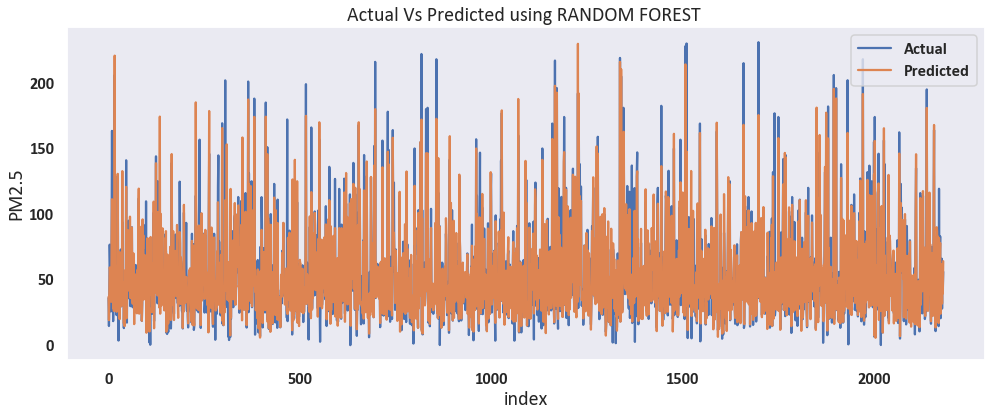

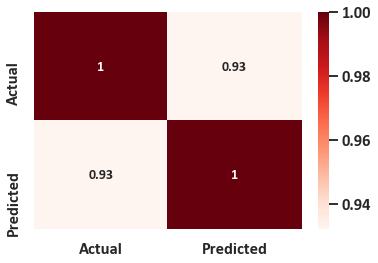

In [30]:
rfr = RandomForestRegressor(n_estimators = 50, random_state = 42) # 50 trees
rfr.fit(X_train_mf, y_train_mf) 
joblib.dump(rfr, 'randomforest_mf_model_1.pkl')
y_pred_mf = rfr.predict(X_test_mf)

df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)


get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'RANDOM FOREST ')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1] 
for f in range(X_train_mf.shape[1]): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) 
    
# Get numerical feature importances
importances = list(rfr.feature_importances_)   
feature_list = list(data_mf.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances]

1. feature 1 (0.492345)
2. feature 3 (0.266413)
3. feature 4 (0.047841)
4. feature 2 (0.045989)
5. feature 0 (0.039713)
6. feature 5 (0.030531)
7. feature 7 (0.022381)
8. feature 9 (0.012946)
9. feature 8 (0.011912)
10. feature 11 (0.010387)
11. feature 6 (0.009058)
12. feature 12 (0.008211)
13. feature 10 (0.001300)
14. feature 13 (0.000973)
pm10                 Importance: 0.49235
s2_pm10              Importance: 0.26641
humidity             Importance: 0.04784
s2_pm2_5             Importance: 0.04599
pm2_5                Importance: 0.03971
temp                 Importance: 0.03053
long                 Importance: 0.02238
greenness            Importance: 0.01295
altitude             Importance: 0.01191
landform_270m        Importance: 0.01039
lat                  Importance: 0.00906
population           Importance: 0.00821
landform_90m         Importance: 0.0013
dist_major_road      Importance: 0.00097


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [32]:
feature_importancesx =  pd.DataFrame(feature_importances, columns=["feature","importance"])
feature_importancesx

,feature,importance
0,pm10,0.49235
1,s2_pm10,0.26641
2,humidity,0.04784
3,s2_pm2_5,0.04599
4,pm2_5,0.03971
5,temp,0.03053
6,long,0.02238
7,greenness,0.01295
8,altitude,0.01191
9,landform_270m,0.01039


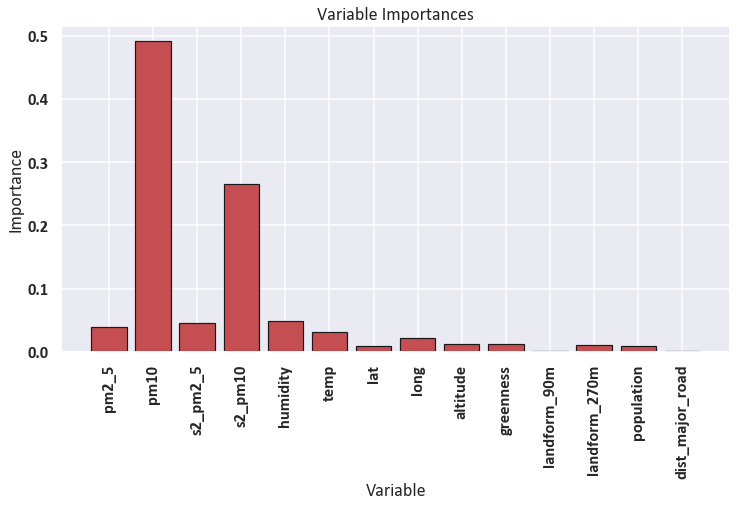

In [33]:
#feature_importancesx.plot(kind='bar',figsize=(12,6))
plt.figure(figsize=(12,6))
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

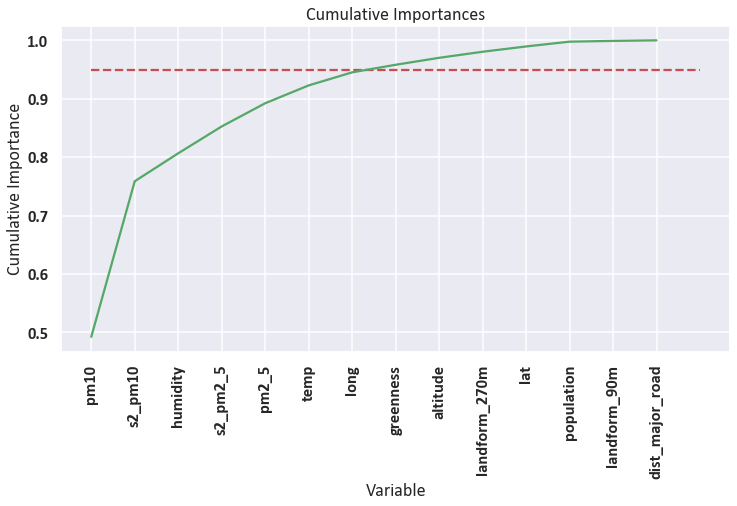

In [34]:
plt.figure(figsize=(12,6))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [35]:
feature_importances

[('pm10', 0.49235),
 ('s2_pm10', 0.26641),
 ('humidity', 0.04784),
 ('s2_pm2_5', 0.04599),
 ('pm2_5', 0.03971),
 ('temp', 0.03053),
 ('long', 0.02238),
 ('greenness', 0.01295),
 ('altitude', 0.01191),
 ('landform_270m', 0.01039),
 ('lat', 0.00906),
 ('population', 0.00821),
 ('landform_90m', 0.0013),
 ('dist_major_road', 0.00097)]

In [36]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:14]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]


Number of features for 95% importance: 8


In [37]:
# Create training and testing sets with only the important features
important_train_features = X_train_mf[:, important_indices]
important_test_features = X_test_mf[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)



Important train features shape: (8728, 14)
Important test features shape: (2183, 14)


      Actual  Predicted
0       36.0     37.260
1       14.7     18.576
2       35.0     37.700
3       76.7     61.070
4       63.7     59.240
...      ...        ...
2178    66.0     60.922
2179    28.0     31.986
2180    60.0     60.518
2181    44.0     39.506
2182    56.0     63.320

[2183 rows x 2 columns]
Mean Absolute Error:  7.452940907008703
Root Mean Squared Error:  12.963515449518107
Mean Squared Error:  168.05273280989465
Correlation:  0.9317806316592185
R-Squared Value:  0.8682


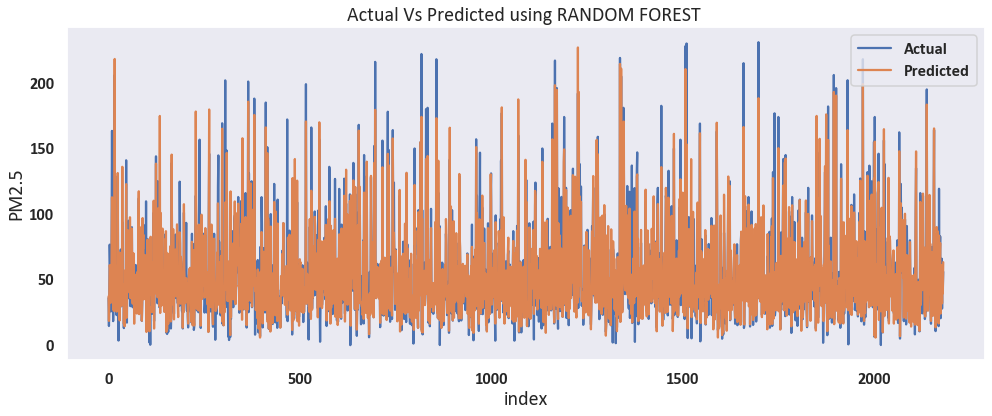

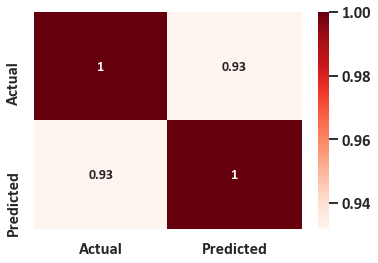

In [38]:
#rfr = RandomForestRegressor(n_estimators = 100 , max_features = 'sqrt', max_depth =50, bootstrap = True, random_state = 42)
rfr.fit(important_train_features, y_train_mf) 
joblib.dump(rfr, 'selected_features_randomforest_mf_model_2.pkl')
y_pred_mf = rfr.predict(important_test_features)

df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)


get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'RANDOM FOREST ')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

In [39]:
##source : https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

## GRID SEARCH & CV

#### best 
{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 100}

# Evaluating  models with multivariate dataset on held out dataset 

In [40]:
data_test[data_test.isna().any(axis=1)]

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
773,2019-12-11 14:00:00+03:00,USEmbassy,11.409091,12.588409,0.000000,0.000000,0.724167,NaN,0.299255,32.592686,...,21,14,6834,130,14,11,2,12,50,2019
817,2019-12-11 08:00:00+03:00,USEmbassy,35.920238,44.365000,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,21,14,6834,130,8,11,2,12,50,2019
1284,2021-01-29 16:00:00+03:00,Nakawa,27.604545,34.014091,26.737045,34.265682,NaN,23.008333,0.331740,32.609510,...,31,-11,4780,500,16,29,4,1,4,2021
1343,2019-12-11 05:00:00+03:00,USEmbassy,24.893182,29.477955,0.000000,0.000000,0.993333,NaN,0.299255,32.592686,...,21,14,6834,130,5,11,2,12,50,2019
1634,2019-12-10 23:00:00+03:00,USEmbassy,60.339091,71.590227,0.000000,0.000000,0.982500,NaN,0.299255,32.592686,...,21,14,6834,130,23,10,1,12,50,2019


In [41]:
data_test.fillna(data_test.mean(), inplace=True)

In [42]:
data_test

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2020-03-20 12:00:00+03:00,USEmbassy,9.903636,10.259545,8.852727,10.097727,0.748000,26.491667,0.299255,32.592686,...,21,14,6834,130,12,20,4,3,12,2020
1,2019-10-12 06:00:00+03:00,USEmbassy,38.428333,45.940714,40.087143,48.159762,0.995000,18.225000,0.299255,32.592686,...,21,14,6834,130,6,12,5,10,41,2019
2,2019-12-13 17:00:00+03:00,USEmbassy,13.278000,14.967333,0.000000,0.000000,0.687500,24.891667,0.299255,32.592686,...,21,14,6834,130,17,13,4,12,50,2019
3,2019-11-13 09:00:00+03:00,USEmbassy,36.304000,40.366750,89.182500,93.572500,0.868417,22.616667,0.299255,32.592686,...,21,14,6834,130,9,13,2,11,46,2019
4,2019-08-07 19:00:00+03:00,USEmbassy,56.686410,67.412308,55.048974,66.089487,0.782083,23.350000,0.299255,32.592686,...,21,14,6834,130,19,7,2,8,32,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2020-01-19 00:00:00+03:00,USEmbassy,75.804091,79.502045,72.147273,80.552273,0.730833,22.300000,0.299255,32.592686,...,21,14,6834,130,0,19,6,1,3,2020
2729,2020-10-25 11:00:00+03:00,Nakawa,20.805238,22.663810,22.465238,24.824048,0.640500,26.825000,0.331740,32.609510,...,31,-11,4780,500,11,25,6,10,43,2020
2730,2021-01-13 06:00:00+03:00,Makerere,76.253333,82.311667,72.468333,81.742500,0.987333,19.291667,0.333501,32.568561,...,21,28,8518,475,6,13,2,1,2,2021
2731,2019-08-13 13:00:00+03:00,USEmbassy,37.669767,44.455581,37.168837,43.949767,0.660667,25.550000,0.299255,32.592686,...,21,14,6834,130,13,13,1,8,33,2019


In [43]:
#data_test_final = data_test.dropna()
#data_test_final = data_test
data_test_mf_ = data_test[numerical_fields]


print(data_test_mf_.shape)
X_data_test = data_test_mf_.values
print(X_data_test.shape)
y_data_test = df_test_solution['ref_pm2_5'].values
print(y_data_test.shape)

(2733, 14)
(2733, 14)
(2733,)


      Actual  Predicted
0       30.0     14.124
1       44.0     38.940
2       27.0     21.960
3       48.0     38.678
4       57.0     55.406
...      ...        ...
2728    75.0     90.592
2729    24.2     26.432
2730    54.0     92.324
2731    42.0     39.286
2732    39.4     43.248

[2733 rows x 2 columns]
Mean Absolute Error:  14.604508598609588
Root Mean Squared Error:  23.765510190945434
Mean Squared Error:  564.7994746359312
Correlation:  0.8514770432880227
R-Squared Value:  0.725


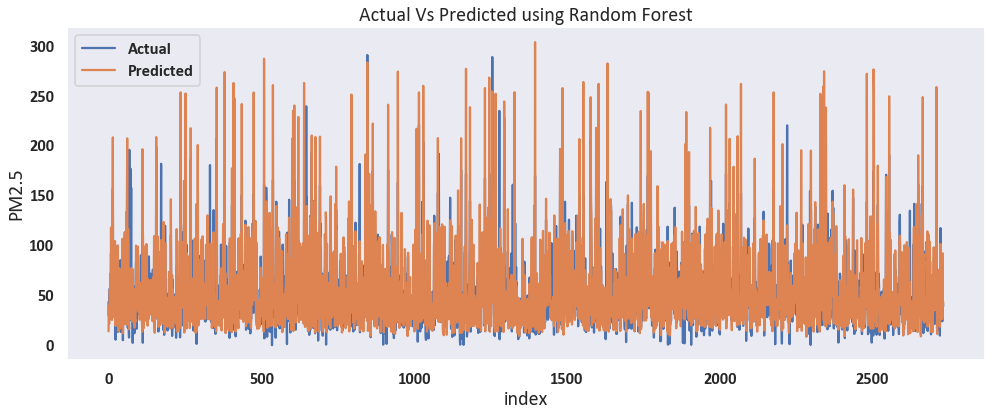

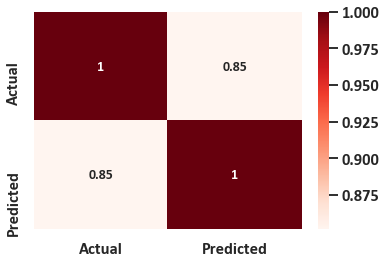

In [44]:
#scaled_evaluation_features_original = test_scaler.fit_transform(X_data_test)
                     
mf_svr_loaded = joblib.load('selected_features_randomforest_mf_model_2.pkl')
y_pred_eval = mf_svr_loaded.predict(X_data_test)
#print(len(y_pred_eval))
#print(y_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'Random Forest')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()
